---
# pRF experiment

This notebook contains an initial analysis of the pRF-data (run-2 and run-5). Each run had 3 iterations of the pRF-design, meaning we will average runs, and iterations.

In [163]:
from linescanning import utils,prf,dataset,plotting
import numpy as np
import warnings
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy import signal
import os
opj = os.path.join

warnings.simplefilter('ignore')
project_dir = os.environ.get("DIR_PROJECTS")
base_dir = os.path.join(project_dir, 'hemifield')
deriv_dir = opj(base_dir, 'derivatives')

plot_vox = 360
plot_xkcd = False
fig_ext = "pdf"
np.set_printoptions(precision=3)


Fetch the files representing the functional data (`bold.mat` > `call_linerecon`), experiment log file `events.tsv` > `exptools2`), regressor file (`physio.txt`) and mat-file (`physio.mat`) physio files (`call_spmphysio`). `run_files` collects all these files in a list, from which we can then pick the required files and store them in their respective variable

In [2]:
# Load data
sub         = '003'
ses         = 3
task        = "task-pRF"
run         = [2,5]
func_dir    = opj(base_dir, f"sub-{sub}", f"ses-{ses}", "func")
anat_dir    = opj(base_dir, f"sub-{sub}", f"ses-{ses}", "anat")
prf_new     = opj(base_dir, 'derivatives', 'prf', f"sub-{sub}", f"ses-{ses}")

if not os.path.exists(prf_new):
    os.makedirs(prf_new, exist_ok=True)

DATASET

FUNCTIONAL
Preprocessing /data1/projects/MicroFunc/Jurjen/projects/hemifield/sub-003/ses-3/func/sub-003_ses-3_task-pRF_run-2_bold.mat
 Filtering strategy: 'lp'
 Cutting 0 volumes from beginning
 DCT-high pass filter [removes low frequencies <0.01 Hz]
 Source dir: /data1/projects/MicroFunc/Jurjen/projects/hemifield/derivatives/nighres/sub-003/ses-1
 Target session: ses-3
 Foldover: FH
 Ref slice: /data1/projects/MicroFunc/Jurjen/projects/hemifield/sub-003/ses-3/anat/sub-003_ses-3_acq-1slice_run-2_T1w.nii.gz
 Trafo's: ['/data1/projects/MicroFunc/Jurjen/projects/hemifield/derivatives/pycortex/sub-003/transforms/sub-003_from-ses1_to-ses3_rec-motion1_desc-genaff.mat', '/data1/projects/MicroFunc/Jurjen/projects/hemifield/sub-003/ses-3/anat/from-run2_to-run2.txt']
 Found 24 voxel for nuisance regression; (indices<300 are ignored due to distance from coil)
 We're good to go!
 Using 5 components for aCompCor (WM/CSF separately)
 Found 1 component(s) in 'csf'-voxels with total explained

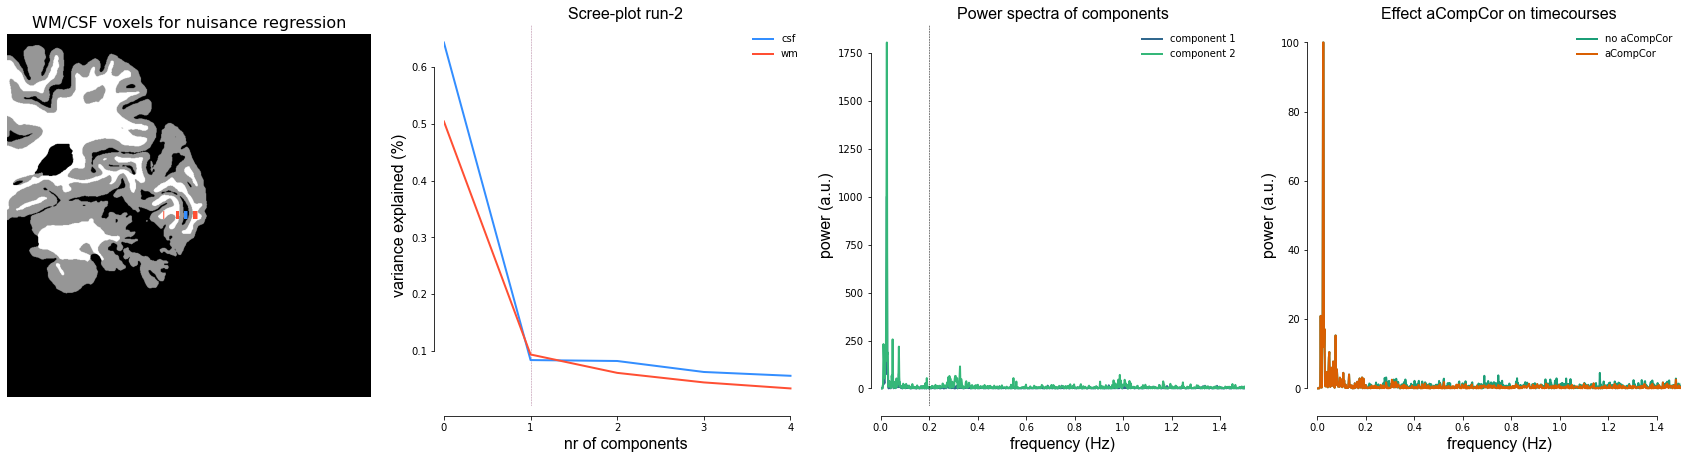

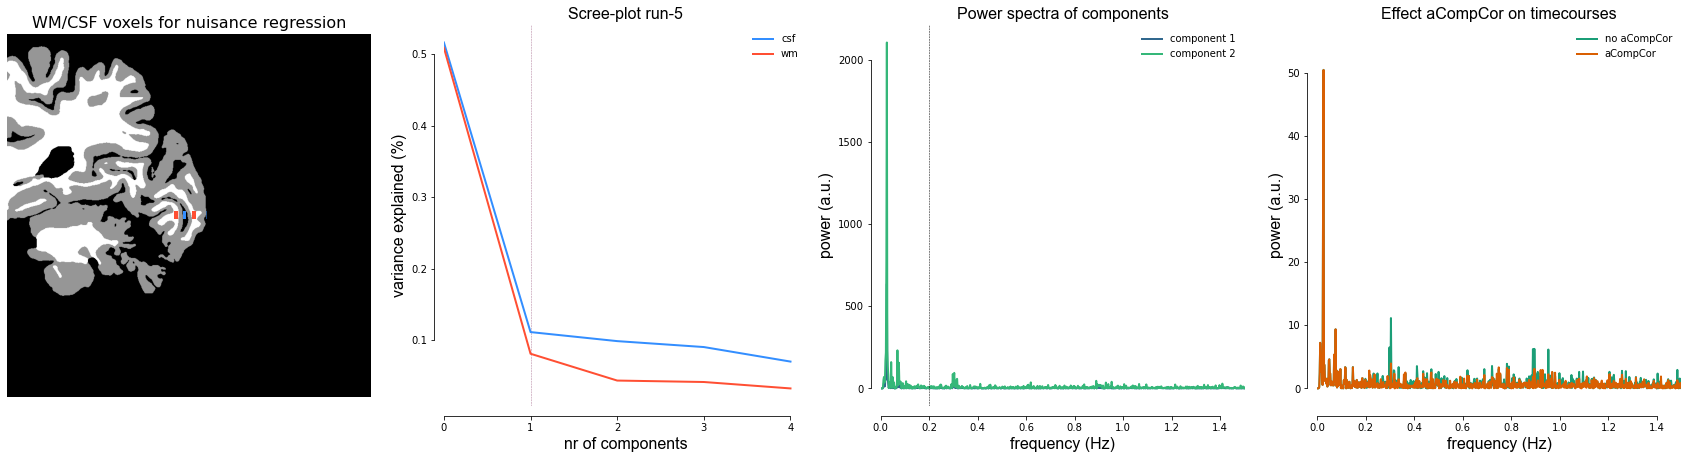

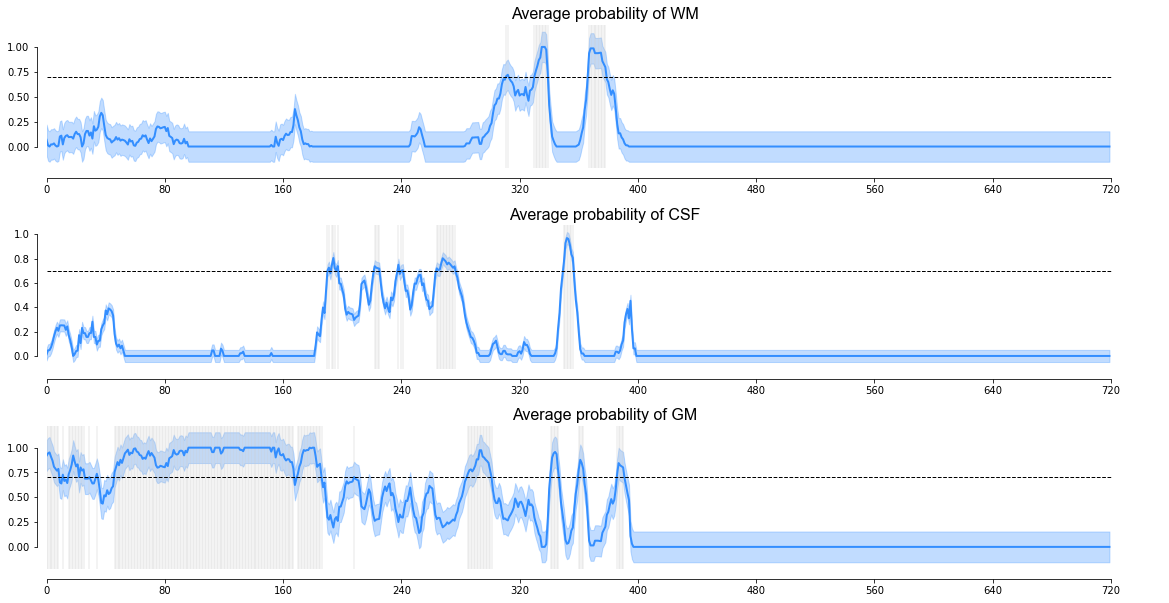

In [3]:
run_files   = utils.get_file_from_substring([f"{task}"], func_dir)
func_file   = utils.get_file_from_substring("bold.mat", run_files)
ref_slices  = [utils.get_file_from_substring(["acq-1slice", f"run-{i}", "nii.gz"], anat_dir) for i in run]

# get transformation files
trafo = utils.get_file_from_substring(f"ses{ses}_rec-motion1", opj(deriv_dir, 'pycortex', f"sub-{sub}", 'transforms'))
trafo_run   = [utils.get_file_from_substring(f"to-run{i}", anat_dir) for i in run]

# initiate object
window = 19
order = 3
func = dataset.Dataset(func_file,
                       window_size=window, # needs to be odd
                       low_pass=True,
                       acompcor=True,
                       ref_slice=ref_slices,
                       ses1_2_ls=trafo,
                       run_2_run=trafo_run,                       
                       poly_order=order,
                       use_bids=True,
                       verbose=True,
                       project_home=base_dir,
                       save_as=opj(anat_dir, f"sub-{sub}_ses-{ses}"))

data        = func.fetch_fmri()
avg_func    = data.groupby(['subject', 't']).mean()
avg_raw     = func.df_func_raw.groupby(['subject', 't']).mean()
avg_gm      = func.gm_df.groupby(['subject', 't']).mean()
avg_ribbon  = func.ribbon_df.groupby(['subject', 't']).mean()

print(avg_func.shape)
avg_func.head()

win11_poly3 = avg_func.copy()

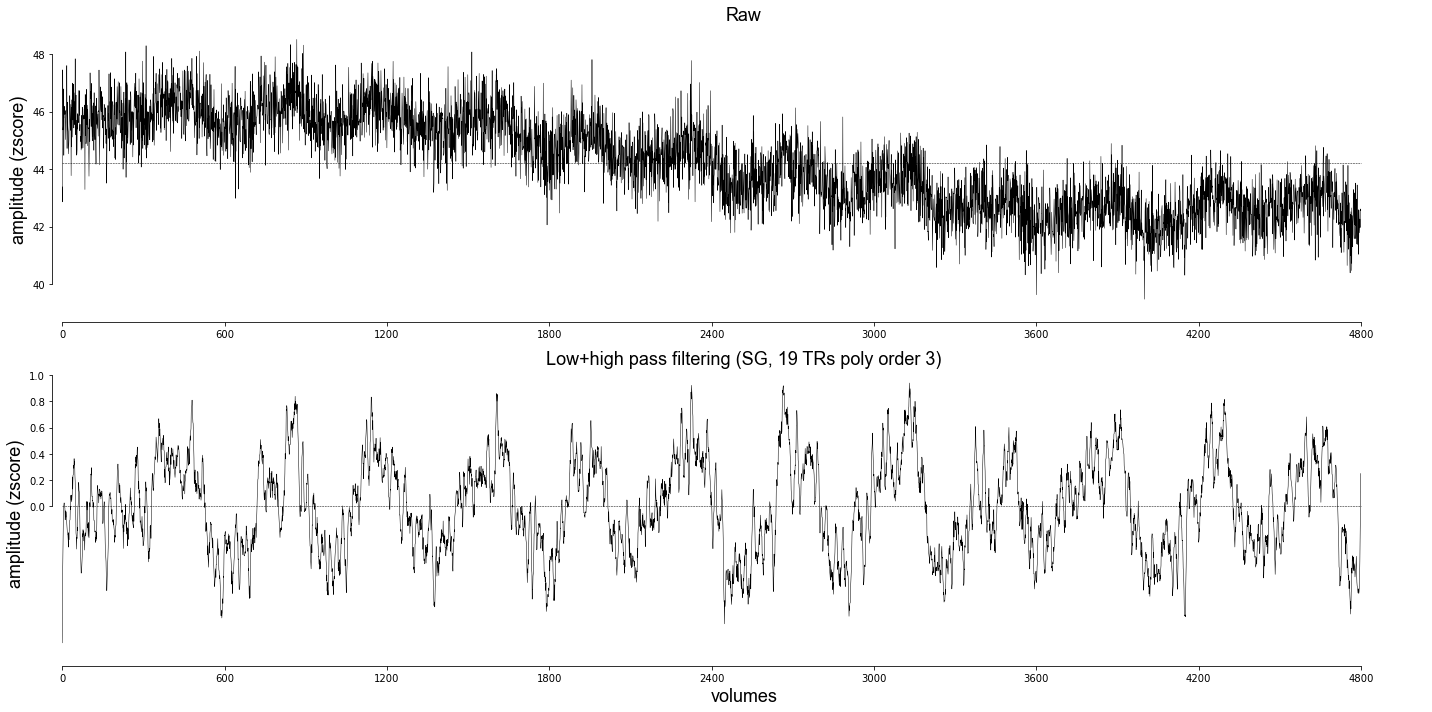

In [4]:
# use this setup so we can add the shaded boxes
fig,axs = plt.subplots(2,1, figsize=(20,10))

# timecourse
plotting.LazyPlot(avg_raw[f'vox {plot_vox}'].values,
                  axs=axs[0],
                  add_hline="mean",
                  line_width=0.5,
                  color="#000000",
                  title="Raw",
                  y_label="amplitude (zscore)",
                  xkcd=plot_xkcd,
                  sns_trim=True,
                  font_size=18)

plotting.LazyPlot(avg_func[f'vox {plot_vox}'].values,
                  axs=axs[1],
                  line_width=0.5,
                  color="#000000",
                  x_label="volumes",
                  title=f"Low+high pass filtering (SG, {window} TRs poly order {order})",
                  y_label="amplitude (zscore)",
                  add_hline='default',
                  xkcd=plot_xkcd,
                  sns_trim=True,
                  font_size=18)                     

plt.tight_layout()
# fig.savefig(opj(func_dir, "filtering.pdf"))

Here we start to chunk up the average timecourse into the individual iterations:
- $baseline_{tr} = 30s / 0.105s \approx 285.71 $ trials. Because we're dealing with volumes and TRs, we need an integer, so let's say $286$
- Each iteration = $160$ seconds, so $160/0.25 \approx 1523.81$ trials. Again, make integer: $1524$ trials per iteration
- We have three iterations, but for some reason the number of trials exceeded the number of volumes (timing of the sequence seems difficult to predict with multi-echo acquisition..?)
- Now I loop through the number of iterations starting from $286$ with steps of $1524$.
- The final iteration doesn't have enough volumes for this operation, so it's zero-padded at the end
- The output of this is a numpy-array with shape `(1524, 720, 3)` for `(<volumes>, <n_voxels>, <iterations>)`, which is then concatenated over the last axis

Q: what to do about the baseline? There's no average for baseline, so if we add the baseline back after averaging we have a rather tumultuous beginning of the timecourse followed by smoother timecourse due to averaging

In [5]:
use_data    = avg_func.copy()
n_iter      = 3
start       = 286
iter_size   = 1524
baseline    = use_data[:start]

iter_chunks = []
for ii in range(n_iter):

    
    # try to fetch values, if steps are out of bounds, zero-pad the timecourse
    if start+iter_size < use_data.shape[0]:
        chunk = use_data.values[start:start+iter_size]
    else:
        chunk = use_data.values[start+iter_size:]
        padded_array = np.zeros((iter_size, use_data.shape[1]))
        padded_array[:chunk.shape[0]] = chunk
        chunk = padded_array.copy()

    iter_chunks.append(chunk[...,np.newaxis])
    start += iter_size
    print(f"Chunk size = {chunk.shape}")

avg_iters_baseline = np.concatenate((baseline, np.concatenate(iter_chunks, axis=-1).mean(axis=-1)))
avg_iters_no_baseline = np.concatenate(iter_chunks, axis=-1).mean(axis=-1)
print(f"Final func data (w/o baseline) has shape: {avg_iters_no_baseline.shape}")

Chunk size = (1524, 720)
Chunk size = (1524, 720)
Chunk size = (1524, 720)
Final func data (w/o baseline) has shape: (1524, 720)


Here I plotted the average timecourse with the iterations marked in shaded bands

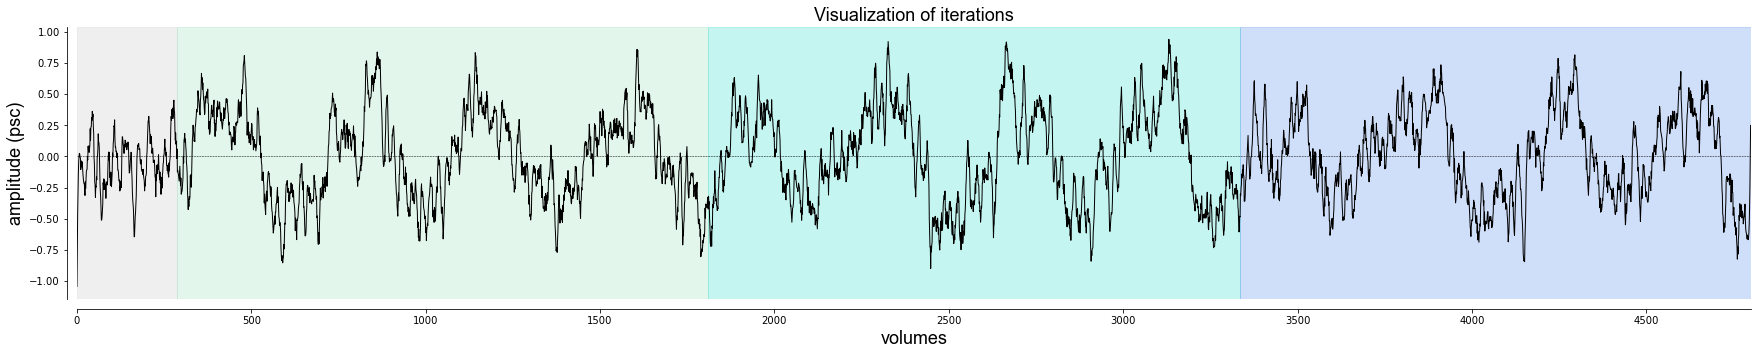

In [6]:
# use this setup so we can add the shaded boxes
fig,axs = plt.subplots(figsize=(30,5))
x = np.arange(0, len(avg_func[f'vox {plot_vox}'].values), step=1)

# shaded boxes for iterations
axs.axvspan(0, 286, alpha=0.3, color="#cccccc")
axs.axvspan(286, 286+iter_size, alpha=0.3, color="#9FE2BF")
axs.axvspan(286+iter_size, 286+(iter_size*2), alpha=0.3, color="#40E0D0")
axs.axvspan(286+(iter_size*2), avg_func.shape[0], alpha=0.3, color="#6495ED")

# timecourse
plotting.LazyPlot(avg_func[f'vox {plot_vox}'].values,
                  axs=axs,
                  line_width=1,
                  color="#000000",
                  x_label="volumes",
                  title="Visualization of iterations",
                  y_label="amplitude (psc)",
                  add_hline='default',
                  sns_trim=False,
                  xkcd=plot_xkcd,
                  x_lim=[0,avg_func[f'vox {plot_vox}'].values.shape[0]],
                  font_size=18)

# fig.savefig(opj(func_dir, "clustering.pdf"))

Below the averaged timecourses across the cortical ribbon at our target vertex without adding back the baseline

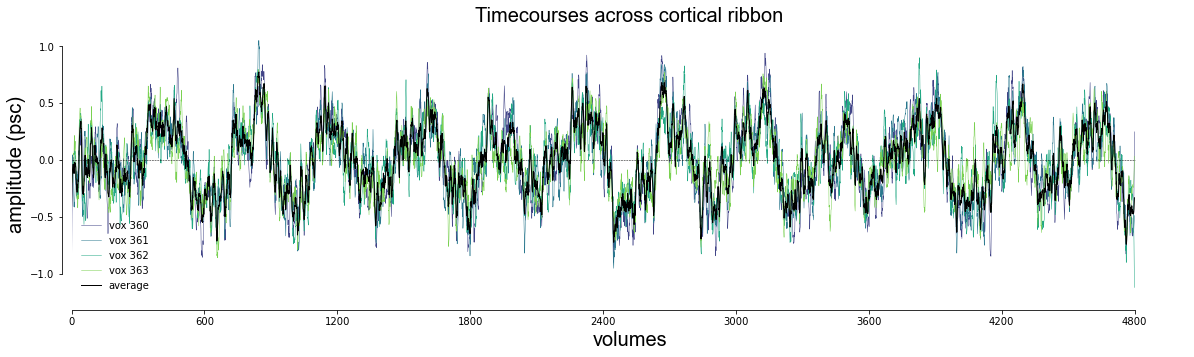

In [7]:
fig,axs = plt.subplots(figsize=(20,5))
data    = [avg_ribbon[ii].values for ii in list(avg_ribbon.columns)]
avg     = avg_ribbon.mean(axis=1).values
labels  = list(avg_ribbon.columns)

# plot individual voxels
plotting.LazyPlot(data,
                  axs=axs,
                  x_label="volumes",
                  y_label="amplitude (psc)",
                  title="Timecourses across cortical ribbon",
                  labels=labels,
                  add_hline='default',
                  sns_trim=True,
                  line_width=0.5,
                  xkcd=plot_xkcd,
                  font_size=20)

# plot average
plotting.LazyPlot(avg,
                  axs=axs,
                  color="#000000",
                  labels=['average'],
                  sns_trim=True,
                  line_width=1,
                  xkcd=plot_xkcd,
                  font_size=18)

# fig.savefig(opj(func_dir, "avg+ribbon.pdf"))

---
# pRF-fitting

Here we fetch relevant pRF-parameters that are required to construct the size-response curve below (this is the same curve as in derivatives/pycortex/<subject>/<subject>_hemi-?_desc-prf_sizeresponse.pdf).

In [131]:
# collect subject data including Normalization parameters
cx_dir = opj(project_dir, 'hemifield', 'derivatives', 'pycortex', f"sub-{sub}")
prf_old = opj(project_dir, 'hemifield', 'derivatives', 'prf', f"sub-{sub}", 'ses-1')
subject_info = utils.CollectSubject(f"sub-{sub}", 
                                    prf_dir=prf_old, 
                                    cx_dir=cx_dir, 
                                    settings='recent', 
                                    hemi="lh", 
                                    model="norm",
                                    verbose=False)

# initiate the SizeResponse class
SR = prf.SizeResponse(subject_info.prf_stim, subject_info.normalization_params, subject_info=subject_info)

# make the stimuli
SR.make_stimuli()

# make the curve
sr_curve1 = SR.make_sr_function(center_prf=True)
sr_curve2 = SR.make_sr_function(center_prf=True, scale_factor=0.8)

# stimsizes are in SR.stims_fill_sizes

[ 1.863e+00 -2.078e+00  8.226e-01  1.437e+00 -3.454e-02  4.658e-02
  9.749e+00  6.957e+01  1.142e+02  9.613e-01]


Create the design matrix

In [9]:
# line pRF
log_dir = "/data1/projects/MicroFunc/Jurjen/projects/hemifield/testing/prf_design/sub-003_ses-0_task-pRF_run-0"
design = prf.create_line_prf_matrix(log_dir, 
                                    stim_duration=0.25,
                                    nr_trs=avg_iters_baseline.shape[0],
                                    TR=0.105,
                                    verbose=True)

design_no_baseline = design[...,286:]
print(design_no_baseline.shape)

Reading onset times from log-file

EXPTOOLS
 1st 't' @42.19s
 Cutting 42.19s from onsets
Creating design matrix (can take a few minutes with thousands of TRs)
(270, 270, 1524)


# Fit on highpass zscore data

In [10]:
avg_gm

vox 0     vox 1     vox 2     vox 3     vox 4     vox 5  \
subject t                                                                     
003     0.000   -0.195287  0.405731 -1.725922 -1.039495 -1.503926 -0.729513   
        0.105   -0.176933  0.291964 -0.969061 -0.724040 -0.929347 -0.209541   
        0.210   -0.152055  0.217733 -0.386860 -0.476560 -0.473759  0.173294   
        0.315   -0.122815  0.177604  0.039207 -0.289317 -0.125254  0.434378   
        0.420   -0.091376  0.166143  0.327666 -0.154569  0.128073  0.589093   
...                   ...       ...       ...       ...       ...       ...   
        503.475 -0.147474  0.285673 -0.121912  0.024081 -0.173099 -0.066212   
        503.580 -0.063306  0.167246 -0.016121  0.040315 -0.170567 -0.070580   
        503.685  0.072899 -0.011819  0.104677  0.040193 -0.176978 -0.129331   
        503.790  0.269054 -0.258914  0.239762  0.020008 -0.195317 -0.254092   
        503.895  0.533073 -0.581427  0.388416 -0.023943 -0.228570 -0.456491   

                    vox 6     vox 7     vox 8    vox 11  ...   vox 346  \
subject t                                                ...             
003     0.000   -0.545276 -1.140004 -0.517430 -1.606725  ... -0.778721   
        0.105   -0.410099 -0.772267 -0.556490 -0.934481  ... -0.603842   
        0.210   -0.301173 -0.466516 -0.541147 -0.414156  ... -0.450194   
        0.315   -0.215781 -0.217707 -0.481272 -0.029217  ... -0.317264   
        0.420   -0.151206 -0.020792 -0.386735  0.236867  ... -0.204538   
...                   ...       ...       ...       ...  ...       ...   
        503.475 -0.263367  0.109765  0.056676  0.098796  ... -0.373538   
        503.580 -0.230355  0.208101 -0.040726  0.089573  ... -0.324198   
        503.685 -0.148137  0.310817 -0.185767  0.063424  ... -0.250468   
        503.790 -0.007226  0.415537 -0.385379  0.017480  ... -0.148095   
        503.895  0.201869  0.519886 -0.646492 -0.051123  ... -0.012830   

                  vox 360   vox 361   vox 362   vox 363   vox 386   vox 387  \
subject t                                                                     
003     0.000   -1.043456 -0.339547 -0.053616 -0.169815 -0.374015 -0.423035   
        0.105   -0.721715 -0.158637 -0.084207 -0.193286 -0.263474 -0.238332   
        0.210   -0.468223 -0.039255 -0.101887 -0.197207 -0.182071 -0.098641   
        0.315   -0.275851  0.026666 -0.108354 -0.184668 -0.126505  0.000640   
        0.420   -0.137470  0.047194 -0.105303 -0.158762 -0.093475  0.064110   
...                   ...       ...       ...       ...       ...       ...   
        503.475 -0.540480 -0.627847 -0.476600 -0.224932 -0.582013 -0.593801   
        503.580 -0.422849 -0.611138 -0.584184 -0.194730 -0.607581 -0.653237   
        503.685 -0.256486 -0.583106 -0.724425 -0.144120 -0.650899 -0.742434   
        503.790 -0.034722 -0.542214 -0.901169 -0.069018 -0.714357 -0.865294   
        503.895  0.249110 -0.486922 -1.118264  0.034659 -0.800346 -1.025716   

                  vox 388   vox 389   vox 390  
subject t                                      
003     0.000   -0.617214 -0.831888 -0.583145  
        0.105   -0.311730 -0.420727 -0.404172  
        0.210   -0.091047 -0.123649 -0.271011  
        0.315    0.054763  0.072490 -0.178050  
        0.420    0.135631  0.180832 -0.119678  
...                   ...       ...       ...  
        503.475 -0.596795 -0.612480 -0.594229  
        503.580 -0.748515 -0.722120 -0.633204  
        503.685 -0.935427 -0.867317 -0.696929  
        503.790 -1.160094 -1.051993 -0.789693  
        503.895 -1.425082 -1.280069 -0.915783  

[4800 rows x 195 columns]

In [11]:
use_model = "norm"
zscore_fit = prf.pRFmodelFitting(avg_iters_no_baseline.T, 
                                 design_matrix=design_no_baseline, 
                                 TR=0.105, 
                                 model=use_model, 
                                 stage='grid+iter', 
                                 verbose=True, 
                                 rsq_threshold=0,
                                 write_files=False)
zscore_fit.fit()

Setting rsq-threshold to user-defined value: 0
Starting gauss grid fit at 2022/04/11 16:06:19
Gaussian gridfit completed at 2022/04/11 16:07:56. voxels/vertices above 0: 720 out of 720
Gridfit took 0:01:36.404162
Mean rsq>0: 0.19818658991910829
Starting gauss iterfit at 2022/04/11 16:07:56
Gaussian iterfit completed at 2022/04/11 16:15:17. Mean rsq>0: 0.19748100388081155
Iterfit took 0:07:21.824842
Using settings file: /mnt/export/data1/projects/MicroFunc/Jurjen/programs/project_repos/pRFline/notebooks/prf/20220411_model-norm_desc-settings.yml
Starting norm grid fit at 2022/04/11 16:15:18


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   13.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   15.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   18.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   20.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   23.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   25.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed: 12.7min finished


Norm gridfit completed at 2022/04/11 16:27:58. Mean rsq>0: 0.47901470957317677
Gridfit took 0:12:39.673800
Starting norm iterfit at 2022/04/11 16:27:58
Norm iterfit completed at 2022/04/12 08:54:32. Mean rsq>0.1: 0.4798887568507813
Iterfit took 16:26:34.508756


In [168]:
ribbon_vox = [int(ii.split(' ')[-1]) for ii in list(func.ribbon_df.columns)]
extended_ribbon = [ribbon_vox[0]-1, *ribbon_vox]
extended_ribbon

[359, 360, 361, 362, 363]

In [157]:
sub

'003'

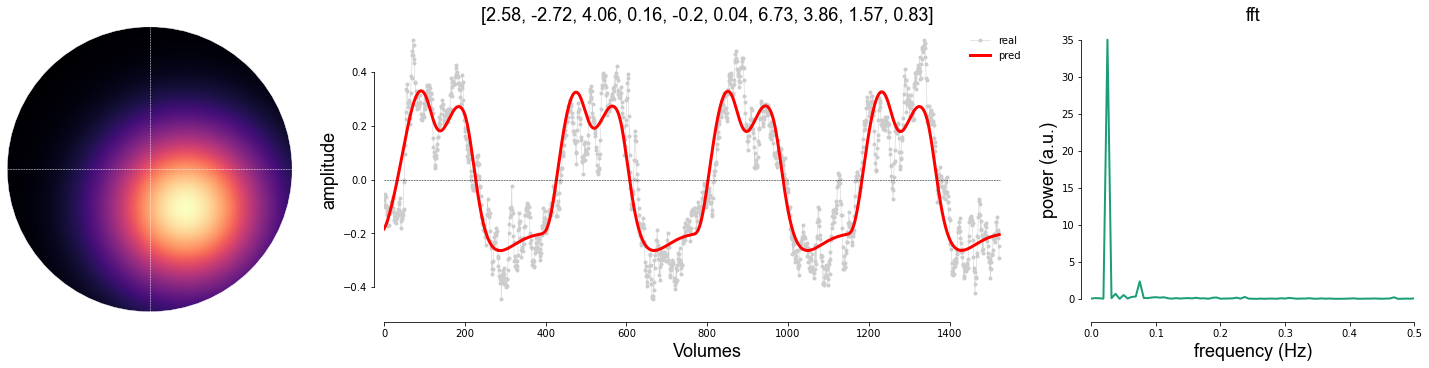

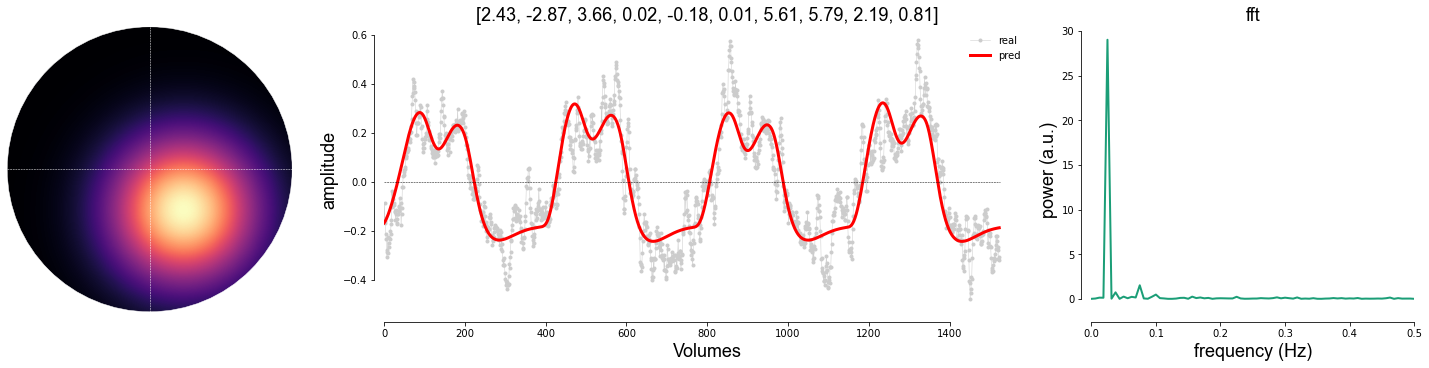

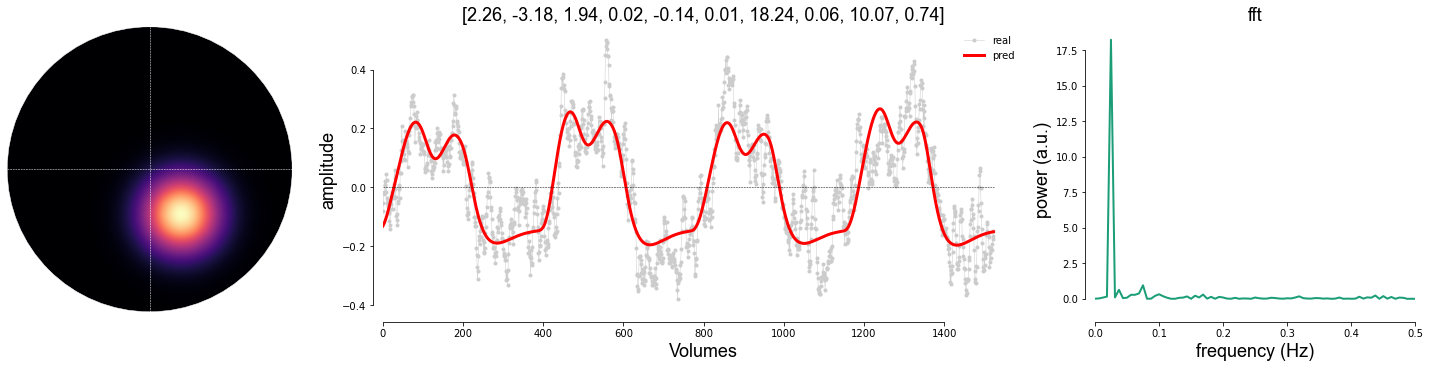

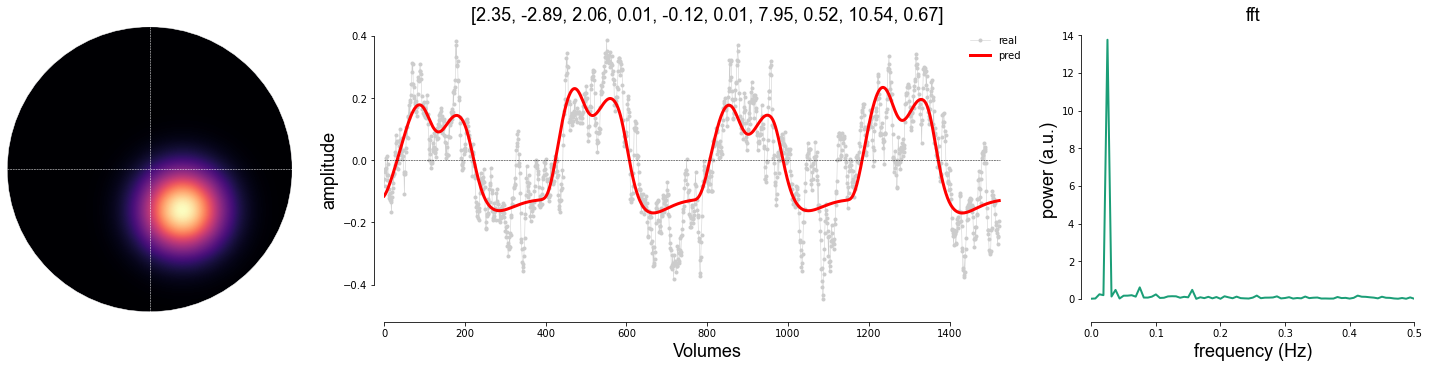

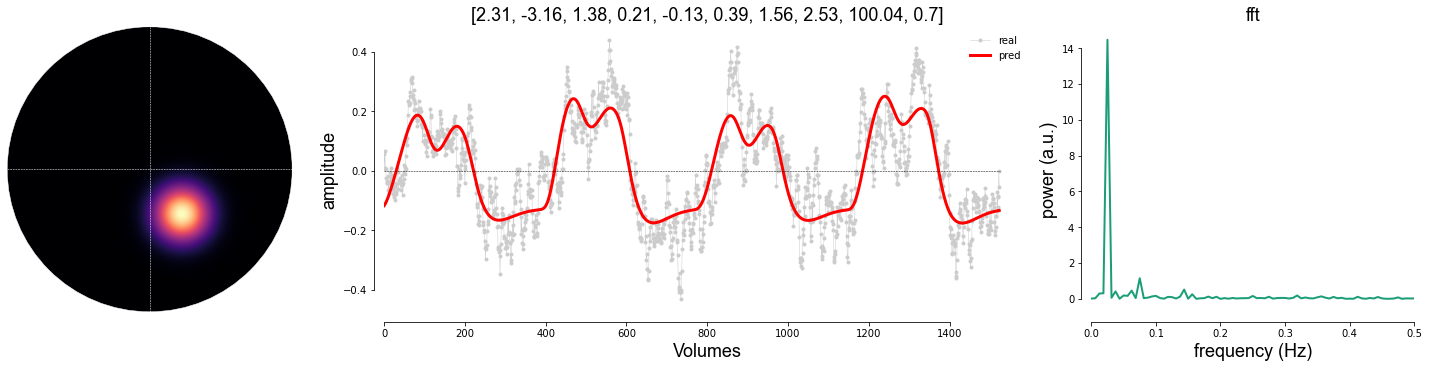

In [164]:
for ix, vox in enumerate(extended_ribbon):
    pars,_,_ = zscore_fit.plot_vox(vox_nr=vox, model='norm', xkcd=False, title='pars', freq_spectrum=True, sns_trim=True, save_as=opj(prf_new, f"sub-{sub}_ses-{ses}_vox-{vox}.{fig_ext}"))

Session 1 - pRF prediction/location:

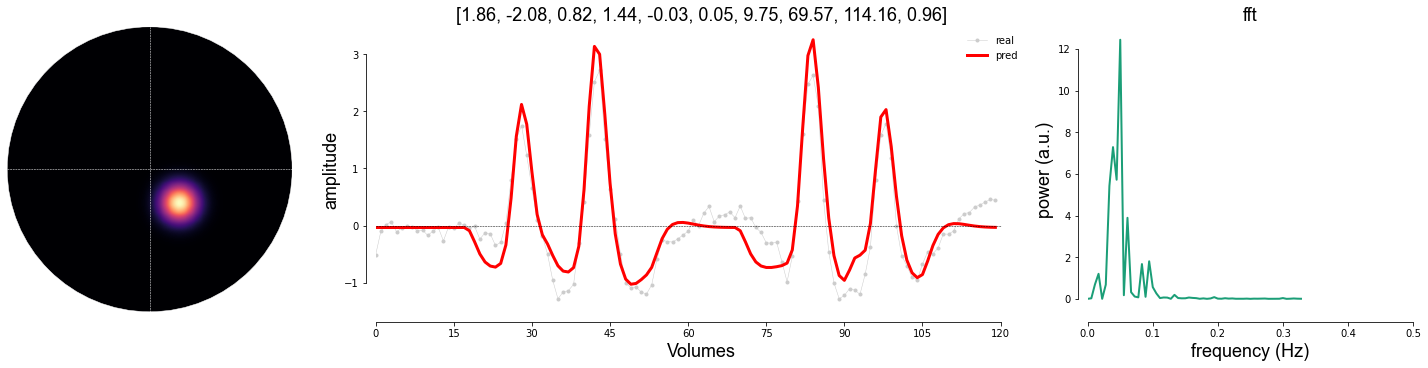

In [165]:
subject_info.target_prediction_prf(xkcd=False, line_width=2, sns_trim=True, freq_spectrum=True, save_as=opj(prf_new, f"sub-{sub}_ses-{ses}_vox-target.{fig_ext}"))

`Vox 359` looks rather similar compared to our target vertex, which is sort of what we wanted. Below I created binary representations of both pRFs for an overlap image

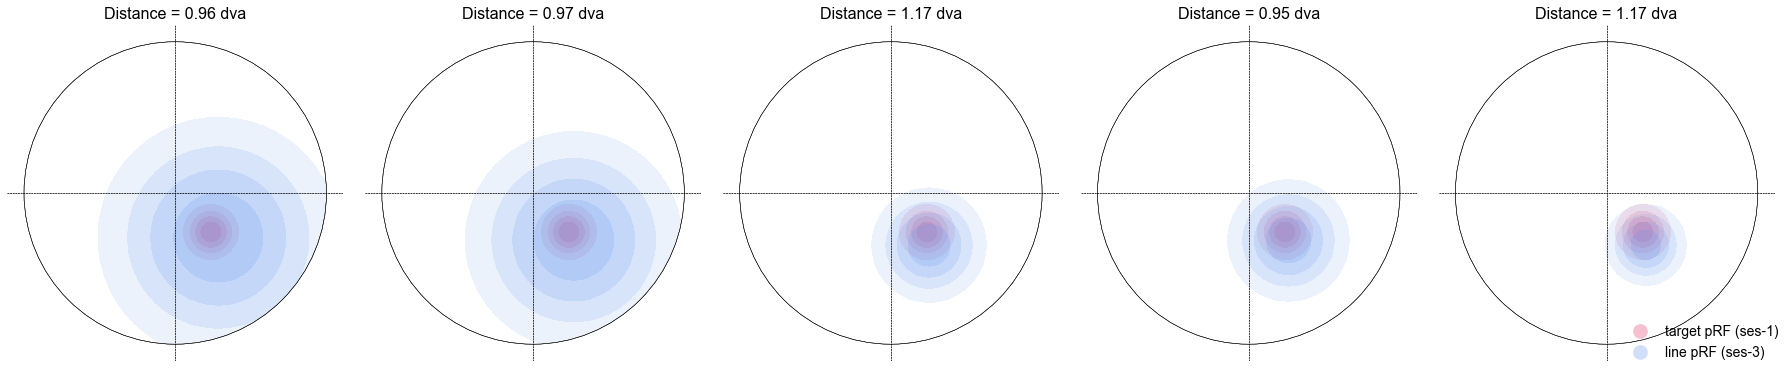

In [166]:
# get linescanning pRF 
fig = plt.figure(figsize=(len(extended_ribbon*5),5))
gs = fig.add_gridspec(1,len(extended_ribbon))

for ix, vox in enumerate(extended_ribbon):
    pars = zscore_fit.norm_iter[vox,...]
    prf_line = prf.make_prf(zscore_fit.prf_stim, size=pars[2], mu_x=pars[0], mu_y=pars[1])

    # get target pRF from ses-1
    prf_target = subject_info.prf_array.copy()

    # create different colormaps
    colors = ["#DE3163", "#6495ED"]
    cmap1 = utils.make_binary_cm(colors[0])
    cmap2 = utils.make_binary_cm(colors[1])
    cmaps = [cmap1, cmap2]
    
    # get distance of pRF-centers
    dist = prf.distance_centers(subject_info.target_params, pars)

    # initiate and plot figure
    axs = fig.add_subplot(gs[ix])
    for ix, obj in enumerate([prf_target,prf_line]):
        plotting.LazyPRF(obj, 
                        vf_extent=subject_info.settings['vf_extent'], 
                        ax=axs, 
                        cmap=cmaps[ix], 
                        cross_color='k', 
                        alpha=0.5, 
                        title=f"Distance = {round(dist, 2)} dva",
                        font_size=16,
                        xkcd=plot_xkcd,
                        shrink_factor=0.9)


# create custom legend
legend_elements = [Line2D([0],[0], marker='o', color='w', label='target pRF (ses-1)', mfc=colors[0], markersize=15, alpha=0.3),
                   Line2D([0],[0], marker='o', color='w', label='line pRF (ses-3)', mfc=colors[1], markersize=15, alpha=0.3)]

# formatting
if plot_xkcd:
    font = "Humor Sans"
else:
    font = "Arial"

L = fig.legend(handles=legend_elements, frameon=False, fontsize=14, loc='lower right')
plt.setp(L.texts, family='Arial')

# overarching title
# fig.suptitle(f"Overlap between target pRF and pRF of line-acquisition (vox {plot_vox})", fontsize=20, fontname=font)

# save img
img = opj(prf_new, f'prf_overlap.{fig_ext}')
fig.savefig(img)
plt.tight_layout()
plt.show()

In [143]:
pars = zscore_fit.norm_iter[extended_ribbon[0]:extended_ribbon[-1]+1,:]
pars_df = prf.SizeResponse.parse_normalization_parameters(pars)
pars_df

,x,y,prf_size,prf_ampl,bold_bsl,neur_bsl,surr_ampl,surr_size,surr_bsl,A,B,C,D,ratio (B/D),r2,size ratio,suppression index
0,2.581467,-2.716852,4.057732,0.158302,-0.198249,3.862536,0.041973,6.731226,-0.198249,0.158302,3.862536,0.041973,1.573947,2.454045,0.830752,1.658864,0.729630
1,2.427699,-2.867464,3.661870,0.023606,-0.180431,5.794229,0.005770,5.611735,-0.180431,0.023606,5.794229,0.005770,2.189218,2.646712,0.807214,1.532478,0.574049
2,2.264550,-3.176508,1.939119,0.020208,-0.144697,0.063485,0.014972,18.238383,-0.144697,0.020208,0.063485,0.014972,10.073047,0.006302,0.741040,9.405502,65.540305
3,2.353826,-2.892625,2.058695,0.013473,-0.124613,0.524649,0.011381,7.950581,-0.124613,0.013473,0.524649,0.011381,10.535688,0.049797,0.670636,3.861952,12.598293
4,2.313856,-3.156581,1.377671,0.205990,-0.128336,2.527839,0.385895,1.558753,-0.128336,0.205990,2.527839,0.385895,100.042791,0.025268,0.703907,1.131441,2.398205


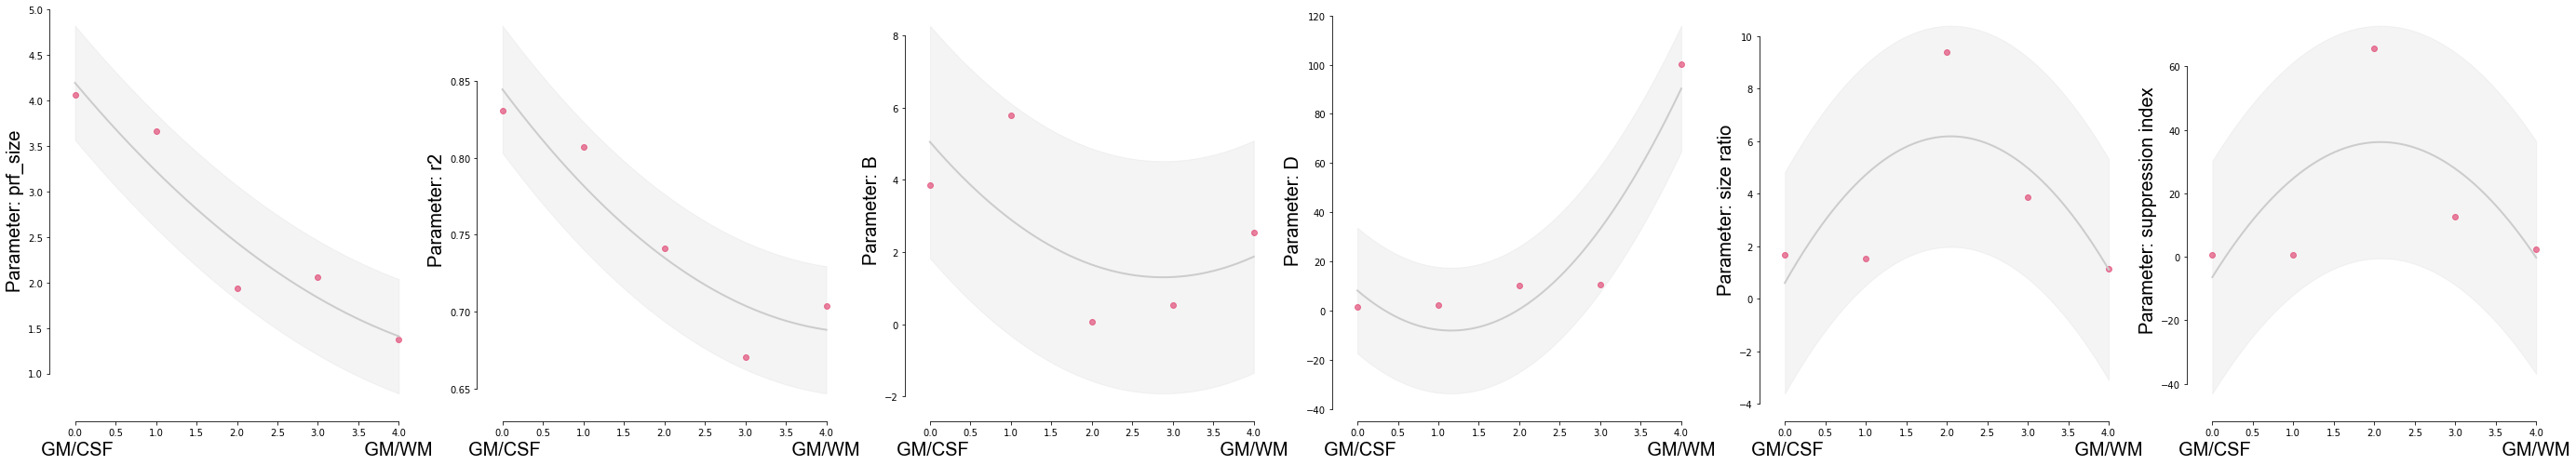

In [173]:
include_params = ["prf_size", "r2", "B", "D", "size ratio", "suppression index"]

fig = plt.figure(figsize=(len(include_params)*8,8))
gs = fig.add_gridspec(1, len(include_params))

for ix,par in enumerate(include_params):
    
    axs = fig.add_subplot(gs[ix])
    vals = pars_df[par].values
    cf = utils.CurveFitter(vals, order=2, verbose=False)

    axs.plot(cf.x, vals, 'o', color=colors[0], alpha=0.6)
    plotting.LazyPlot(cf.y_pred_upsampled,
                    xx=cf.x_pred_upsampled,
                    error=cf.ci_upsampled,
                    axs=axs,
                    color="#cccccc",
                    error_alpha=0.2,
                    x_label="GM/CSF                                                 GM/WM",
                    y_label=f"Parameter: {par}",
                    set_xlim_zero=False,
                    sns_trim=True,
                    line_width=2,
                    xkcd=plot_xkcd,
                    font_size=20)

# save img
# img = opj(prf_new, f'prf_depth.{fig_ext}')
# fig.savefig(img)

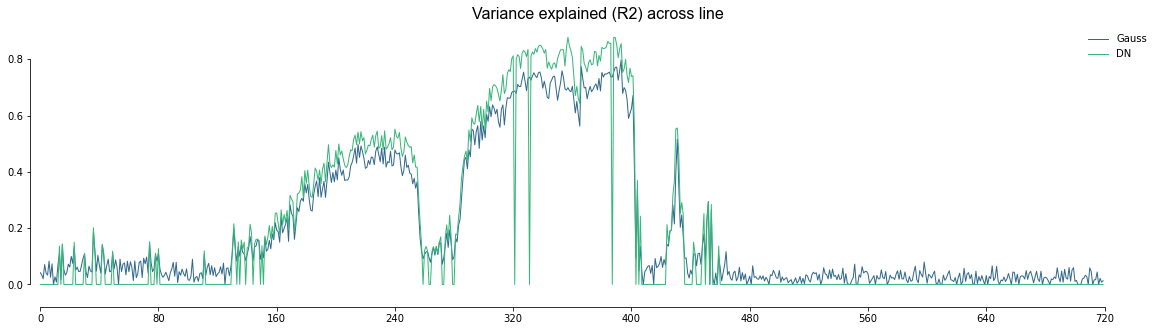

In [170]:
plotting.LazyPlot([zscore_fit.gauss_iter[:,-1], zscore_fit.norm_iter[:,-1]], 
                  sns_trim=True, 
                  title="Variance explained (R2) across line", 
                  font_size=16, 
                  figsize=(20,5),
                  labels=['Gauss', 'DN'])